In [1]:
import h5py
import numpy as np
import keras
import tensorflow as tf
import pandas as pd
import gc

np.random.seed(617)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from sklearn.model_selection import StratifiedKFold

from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

from clr_callback import CyclicLR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import gc

from time import time

import matplotlib.pyplot as plt


/home/danielchan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(tf.__version__)
print(keras.__version__)

1.8.0
2.2.0


In [3]:
def train_model(train_data,train_labels,validation_data,validation_labels,
                num_classes,nb_epoch=50,batch=512, weights=None):
    nb_train_samples = train_data.shape[0]

    CLR = True
    seed = 2018
    
    t_labels = keras.utils.to_categorical(train_labels, num_classes=num_classes)
    v_labels = keras.utils.to_categorical(validation_labels, num_classes=num_classes)

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cvs_acc = []
    cvs_loss = []
    
    fp1 = []
    tp1 = []
    fp2 = []
    tp2 = []
    pr = []
    ac1 = []
    ac2 = []
    
    for train, test in kfold.split(train_data, train_labels):

        model = Sequential()
        model.add(Flatten(input_shape=train_data.shape[1:]))

        model.add(Dense(1024, activation='relu',kernel_regularizer=regularizers.l2(1.e-3)))
        model.add(BatchNormalization())

        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=SGD(momentum=0.8), loss='categorical_crossentropy', 
                       metrics=['accuracy']) 

        if (CLR):
            clr = CyclicLR(base_lr=1e-3, max_lr=0.01,
                       step_size=1*np.ceil(train_data.shape[0]/batch), mode='triangular')
            callbacks_list = [clr] 

        
        history = model.fit(train_data[train,:], t_labels[train,:],
              epochs=nb_epoch, batch_size=batch,
              validation_data=(train_data[test,:], t_labels[test,:]), class_weight=weights,
              callbacks=callbacks_list, verbose=0)
        
        history_plot(history)
        probs = model.predict(train_data[test,:],batch_size=32,verbose=0)
        print ('Confusion Matrix')
        print (confusion_matrix(train_labels[test], np.argmax(probs[:,],axis=1))   )
    
        fpr, tpr, thresholds = roc_curve(train_labels[test], probs[:,0], 0)
        roc_auc = auc(fpr, tpr)
        fp1.append(fpr[0:])
        tp1.append(tpr[0:])
        ac1.append(roc_auc)


        print ( 'AUC_1=',roc_auc)


    
        fpr, tpr, thresholds = roc_curve(train_labels[test], probs[:,2], 2)
        roc_auc = auc(fpr, tpr)
        fp2.append(fpr[0:])
        tp2.append(tpr[0:])
        ac2.append(roc_auc)
        pr.append(probs[:,:])

        print ( 'AUC_2=',roc_auc)
        
        scores = model.evaluate(train_data[test,:], t_labels[test,:],verbose=0)
        
        print(model.metrics_names[0], scores[0])        
        
        cvs_loss.append(scores[0])

        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
        scores = model.evaluate(validation_data, v_labels,verbose=0)
        print ('validation score ', scores[0], scores[1]*100)
              
        cvs_acc.append(scores[1] * 100)
    
    print(np.mean(cvs_loss), np.std(cvs_loss)) 
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvs_acc), np.std(cvs_acc)))            
    
    #fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2,figsize=(4,4))
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    for m in range(5): 
        ax1.plot(fp1[m],tp1[m],label=str(m)+'_AUC = %0.2f' % ac1[m])
    ax1.grid(True)
    ax1.legend(loc="lower right")
    ax1.set_title("Melanoma AUC")
        
    ax2.set_xlabel('False Positive Rate')
    for m in range(5): 
        ax2.plot(fp2[m],tp2[m],label=str(m)+'_AUC = %0.2f' % ac2[m])
    ax2.grid(True)
    ax2.legend(loc="lower right")
    ax2.set_title("Seborrheic Keratosis AUC")
    plt.show()    

    fig.savefig('VGG16_added_images_AUC_plots.jpeg',dpi=600)
    
    
    
    return model,history

In [4]:
def history_plot(history):

    %matplotlib inline

#_, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig, (ax1, ax2) = plt.subplots(1,2) 
    
    fig.tight_layout()
    ax1.grid(True)
    ax2.grid(True)
#    ax1.set_yscale("log", nonposy='clip')
#    ax2.set_yscale("log", nonposy='clip')

    
    
    
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'validation'], loc='lower right')

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'validation'], loc='upper right')

    plt.show()
    fig.savefig('history_RES50_CV_plots.jpeg',dpi=600)

    return

processing  RES50
(2000, 7, 7, 2048)
(2000,)
(600, 7, 7, 2048)
(600,)
3
{0: 1.7825311942959001, 1: 0.4859086491739553, 2: 2.6246719160104988}
None


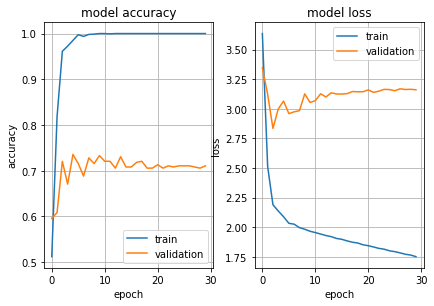

Confusion Matrix
[[ 25  43   7]
 [ 26 236  13]
 [  9  18  24]]
AUC_1= 0.6984458077709611
AUC_2= 0.7971988795518208
loss 3.1607835477129775
acc: 71.07%
validation score  3.0821975453694663 68.33333325386047


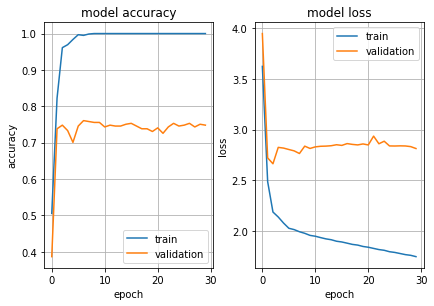

Confusion Matrix
[[ 33  33   9]
 [ 24 237  14]
 [  8  13  30]]
AUC_1= 0.7808179959100204
AUC_2= 0.877422969187675
loss 2.8122343238155145
acc: 74.81%
validation score  3.026107390721639 68.33333325386047


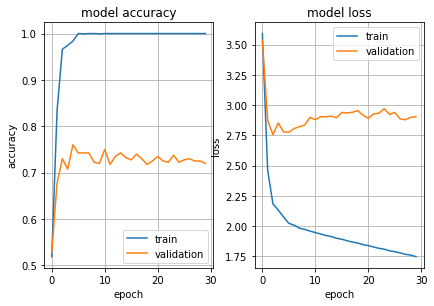

Confusion Matrix
[[ 35  35   5]
 [ 37 221  16]
 [  7  12  32]]
AUC_1= 0.7887179487179488
AUC_2= 0.8662284397999888
loss 2.903738613128662
acc: 72.00%
validation score  3.20906862894694 66.3333334128062


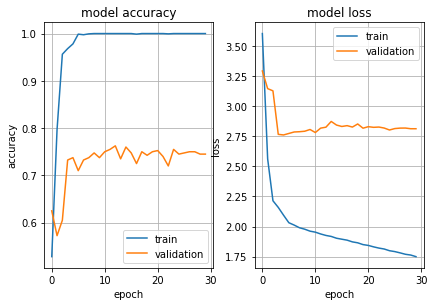

Confusion Matrix
[[ 34  35   6]
 [ 23 233  18]
 [  8  12  31]]
AUC_1= 0.7811692307692308
AUC_2= 0.8956682959716838
loss 2.812850389480591
acc: 74.50%
validation score  2.972576764424642 66.16666666666666


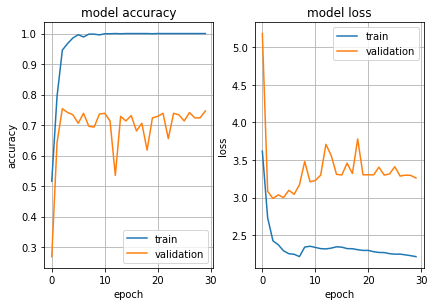

Confusion Matrix
[[ 31  37   6]
 [ 22 238  14]
 [  7  15  28]]
AUC_1= 0.7754421087754422
AUC_2= 0.8582183908045977
loss 3.2615771245716805
acc: 74.62%
validation score  3.409832941691081 68.66666674613953
2.990236799741885 0.1861958761041374
67.57% (+/- 1.08%)


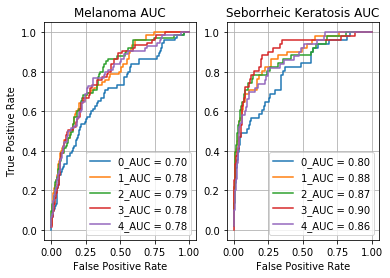

Training Time:  381.10497999191284


In [5]:
models = ['VGG16', 'RES50','IRV2','XCP']
models = ['IRV2','XCP']
models = ['RES50','VGG16']
models = ['RES50']

prefix = 'Sq_orig'
#prefix = 'Sq_orig_added_images'


#prefix = 'Arg2'
#prefix = 'Orig_norm'
#prefix = 'Arg3000'
#prefix = 'ArgSq'
#prefix = 'Arg10'

for m in models:
    print ('processing ',m)
    d1 = np.load(str(prefix) + '_train_features_ISIC_' + str(m))
    d2 = np.load('Sq_orig_test_features_ISIC_'+ str(m))
    #d2 = np.load(str(prefix) + '_test_features_ISIC_' + str(m))
    
    print(d1['features'].shape)
    print(d1['labels'].shape)

    print(d2['features'].shape)
    print(d2['labels'].shape)

    
    num_classes = 3
    print (num_classes)
    
    classes = np.unique(d1['labels'])
    keys = [0,1,2]
    weights = dict(zip(keys,compute_class_weight('balanced', classes, d1['labels'])))
    print (weights) 
    
    train_data = d1['features']
    train_labels = d1['labels']
    validation_data = d2['features']
    validation_labels = d2['labels'] 
    
    del d1,d2
    gc.collect()
    
    wc = None
    print (wc) 
    
    start = time()
    model,history = train_model(train_data,train_labels,validation_data,validation_labels,
                          num_classes=3,nb_epoch=30,batch=32, weights=wc)
    print ('Training Time: ', time()-start)
